In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
import math
import plotly.express as px
from fitter import Fitter, get_common_distributions, get_distributions

In [2]:
data = pd.read_csv('model_data.csv')
data['PO_Document_Date'] = pd.to_datetime(data['PO_Document_Date'] , format='%Y-%m-%d')

In [3]:
data['PO_Document_Date'] = pd.to_datetime(data['PO_Document_Date'], format='%Y-%m-%d')
data['days_late'] = np.where(data['days_late'] > 0, data['days_late'], 0)
data = data[data['days_late'] < 25]

In [5]:
def joint_distributions(input_data :pd.DataFrame, mg : str, increment_size):
    mg_dat = input_data[input_data['Material_Group']==mg]
    mg_dat['days_late'] = pd.to_numeric(mg_dat['days_late'])
    grouped = mg_dat.groupby('Vendor_number').resample('M', on='PO_Document_Date')
    late_p = grouped.mean()['days_late'].reset_index()

    dates = list(late_p['PO_Document_Date'].unique())
    MVEF_Ingest = pd.DataFrame({'Month': dates})
    keep_columns = ['Month']
    perf_columns = []
    for Vendor_number in set(late_p['Vendor_number']):
        sup_data = late_p[late_p['Vendor_number'] == Vendor_number][['PO_Document_Date', 'days_late']]
        non_nulls = [x for x in sup_data['days_late'] if x > -1000]
        if late_p[late_p['Vendor_number'] == Vendor_number]['days_late'].count() < 12:
            continue
        sup_data = sup_data.rename(
            columns={'days_late': f'{Vendor_number} days_late', 'PO_Document_Date': f'{Vendor_number}_date'})
        keep_columns.append(f'{Vendor_number} days_late')
        perf_columns.append(f'{Vendor_number} days_late')
        MVEF_Ingest = pd.merge(MVEF_Ingest, sup_data, how='left', left_on='Month', right_on=f'{Vendor_number}_date')
    # keep_columns = ['Month','539861 days_late','566041 days_late','505439 days_late']
    # perf_columns = ['539861 days_late','566041 days_late','505439 days_late']
    MVEF_Ingest = MVEF_Ingest[keep_columns]
    MVEF_Clean = MVEF_Ingest[perf_columns].interpolate(method='linear', axis=0, limit_direction='forward')
    MVEF_Clean['Month'] = MVEF_Ingest['Month']
    MVEF_Clean = MVEF_Clean.dropna()
    MVEF_Clean = MVEF_Clean[keep_columns]
    MVEF_Clean = MVEF_Clean.sort_values(['Month'], ascending=True)

    actual_weights = mg_dat.groupby('Vendor_number').agg('nunique')[['PO_Number']]
    # actual_weights = actual_weights / actual_weights.sum()
    actual_weights = actual_weights.transpose()
    ac_suppliers = actual_weights.columns
    change_dic = {}
    for sup in ac_suppliers:
        change_dic[sup] = str(sup) + ' days_late'
    actual_weights = actual_weights.rename(columns=change_dic)
    actual_weights = actual_weights[perf_columns]
    actual_weights = actual_weights.transpose()
    actual_weights = actual_weights / actual_weights.sum()
    actual_weights = actual_weights.transpose()
    actual_weights = actual_weights.round(2)

    binned_frame = pd.DataFrame()
    for supplier in perf_columns:
        binned_frame[f'{supplier}'] = np.where(MVEF_Clean[f'{supplier}'] <= 0, 0,
                                        np.where(
                                            (MVEF_Clean[f'{supplier}'] > 0) & (MVEF_Clean[f'{supplier}'] <= 2), 1,
                                        np.where(
                                            MVEF_Clean[f'{supplier}'] > 2, 2, 'FLAG: BINNING ERROR'
                                            )
                                        )
                                    )
        binned_frame[f'{supplier}'] = pd.to_numeric(binned_frame[f'{supplier}'])
    # fig, ax = plt.subplots(nrows=1, ncols=len(perf_columns), figsize=(15, 6))
    # for index, supplier in enumerate(perf_columns):
    #     plot = sns.histplot(
    #         data=binned_frame[supplier],
    #         kde=False,
    #         element='step',
    #         ax=ax[index],
    #         bins=[0,1,2,3],
    #         stat='density',
    #         label='Actual',
    #         color='Green'
    #     )
    #     plot.set_xlabel('Days Late')
    #     Name = supplier.split()[0] + ' ' +supplier.split()[1]
    #     plot.set_title(f'{Name}')
    #     plt.tight_layout()
    binned_frame['Prob_Counter'] = 1
    joint_prob = binned_frame.groupby(perf_columns).agg('count')['Prob_Counter'].reset_index()
    joint_prob['Probability'] = joint_prob['Prob_Counter'] / sum(joint_prob['Prob_Counter'])
    return joint_prob, perf_columns, actual_weights, MVEF_Clean

In [27]:
joint_dist, perf_columns, actual_weights, MVEF_Clean = joint_distributions(input_data=data, mg='017', increment_size=.1)

/var/folders/ng/clzczwr96wz__2znzb2hjykr0000gn/T/ipykernel_24461/1677062943.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mg_dat['days_late'] = pd.to_numeric(mg_dat['days_late'])


In [28]:
MVEF_Clean

,Month,539850 days_late,578425 days_late,539861 days_late,566041 days_late,505439 days_late
43,2018-12-31,5.000000,0.000000,0.0,0.000000,0.130435
44,2019-01-31,5.000000,0.000000,0.0,0.000000,0.130435
25,2021-03-31,0.000000,1.217391,0.0,0.000000,0.312500
26,2021-04-30,2.666667,1.379310,0.0,0.000000,1.894737
27,2021-05-31,0.000000,2.900000,0.0,1.000000,3.333333
28,2021-06-30,0.000000,0.833333,0.0,0.166667,6.606061
29,2021-07-31,0.000000,4.111111,0.0,0.000000,4.076923
30,2021-08-31,1.555556,4.642857,0.0,0.000000,9.294118
31,2021-09-30,3.111111,0.214286,0.0,0.000000,3.612903
32,2021-10-31,4.666667,0.000000,0.0,0.000000,5.160000


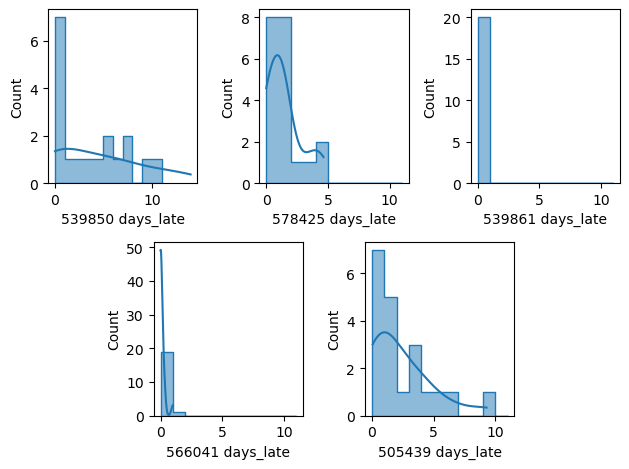

In [29]:
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

axes = [ax1,ax2,ax3,ax4,ax5]

for index, supplier in enumerate(perf_columns):
    sns.histplot(
        data=MVEF_Clean[supplier],
        kde=True,
        element='step',
        ax=axes[index],
        bins = [0,1,2,3,4,5,6,7,8,9,10,11]
    )
plt.tight_layout()

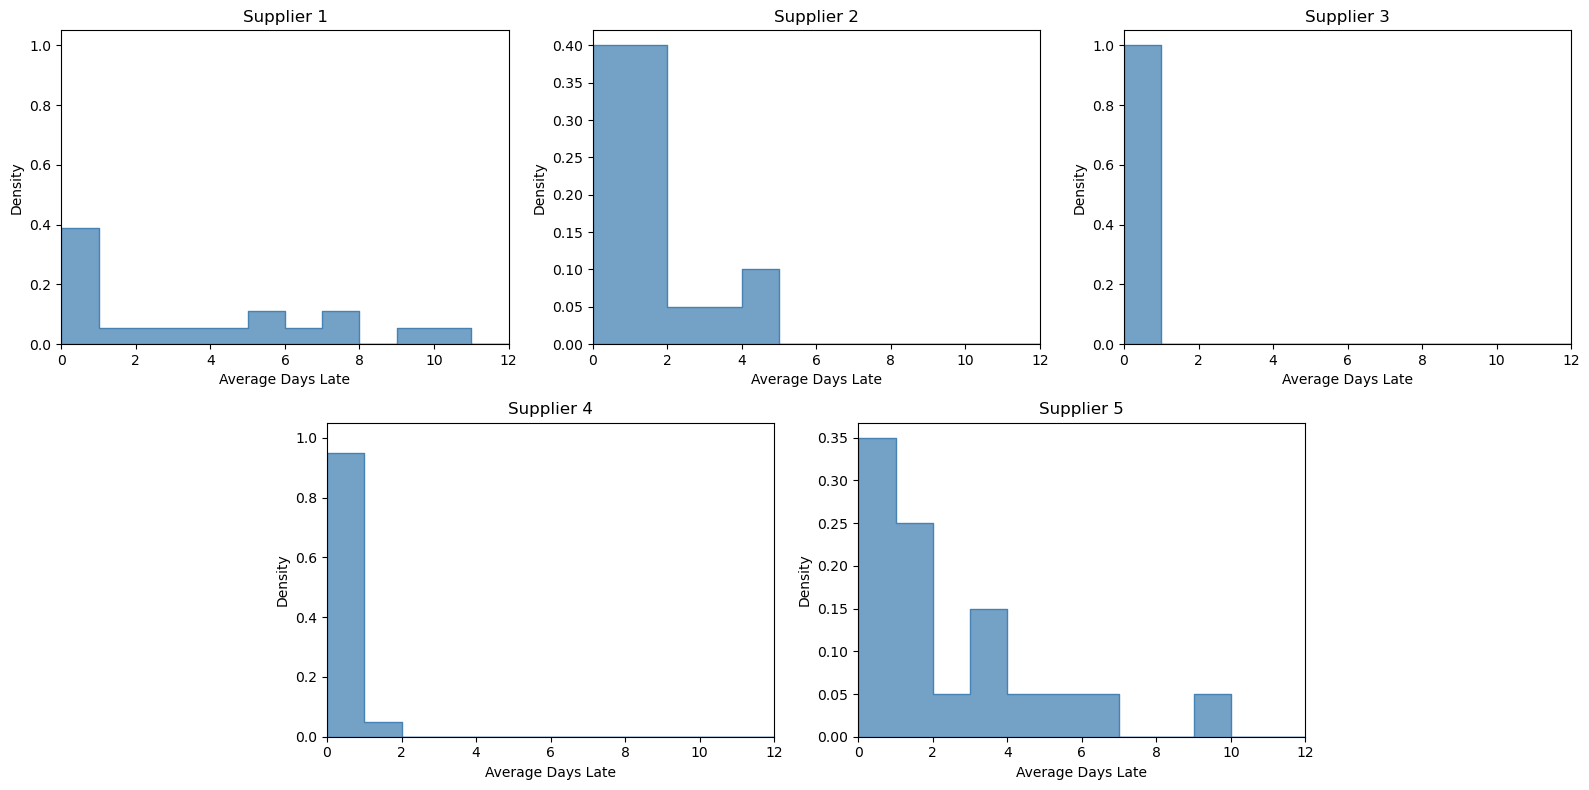

In [58]:
# from matplotlib.pyplot import figure
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(16)

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
axes = [ax1,ax2,ax3,ax4,ax5]
bins = [0,1,2,3,4,5,6,7,8,9,10,11,12]
for index, supplier in enumerate(perf_columns):
    mu = MVEF_Clean[supplier].mean()
    std = MVEF_Clean[supplier].std()
    plot = sns.histplot(
        data=MVEF_Clean[supplier],
        kde=False,
        element='step',
        ax=axes[index],
        bins=bins,
        stat='density',
        label='Actual',
        color='steelblue'
    )
    plot.set_xlabel('Average Days Late')
    Name = f"Supplier {index + 1}"
    plot.set_title(f'{Name}')
    p = len(MVEF_Clean[MVEF_Clean[supplier]==0]) / len(MVEF_Clean[supplier])
    if p==0:
        p=.2
    if p==1:
        p=.9
    z = np.random.geometric(p=p, size=10000)
    z = [i-1 for i in z]
    sns.histplot(
        data=z,
        kde=True,
        element='step',
        ax=axes[index],
        bins=bins,
        color='red',
        label='Geo',
        stat='density'
    )
    plot.legend(labels=['Geo','Actual'])
    axes[index].set_xlim([0, 12])
    if index in (0,2,3):
        axes[index].set_ylim([0, 1.05])
plt.tight_layout()
plt.savefig('test.png')

In [59]:
o17 = data[data['Material_Group']=='017']
len(o17[o17['days_late']==0])/len(o17)

0.7334502411223148